# Binary Classification with Pytorch

In [100]:
# Import Required libraries
import pandas as pd
import torch
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib
import warnings
import PIL
import PIL.Image
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [74]:
# Navigate to where data has been stored
train_dir = os.path.join("data_binary", "data")

In [75]:
#Check the training data
labels = os.listdir(train_dir)
labels

['antelope', 'blanks']

#### Count the number of images available for Binary classification

In [76]:
# Antelope count
antelope_img_path = os.path.join(train_dir, "antelope")
antelope_images = os.listdir(antelope_img_path)
print(f"Antelope count: {len(antelope_images)}")

# Blanks count
blank_imgs_path = os.path.join(train_dir, "blanks")
blank_imgs = os.listdir(blank_imgs_path)
print(f"Blanks count: {len(blank_imgs)}")

Antelope count: 109
Blanks count: 140


#### Display an image

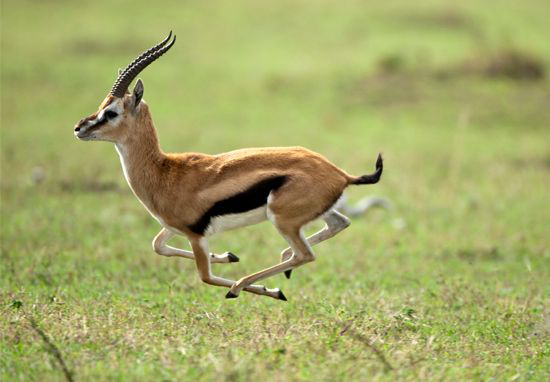

In [8]:
# Path to an antelope image
antelope_image_pic_path = antelope_images[1]
antelope_img_pic = os.path.join(antelope_img_path, antelope_image_pic_path)
antelope_img_Pil = Image.open(antelope_img_pic)
antelope_img_Pil

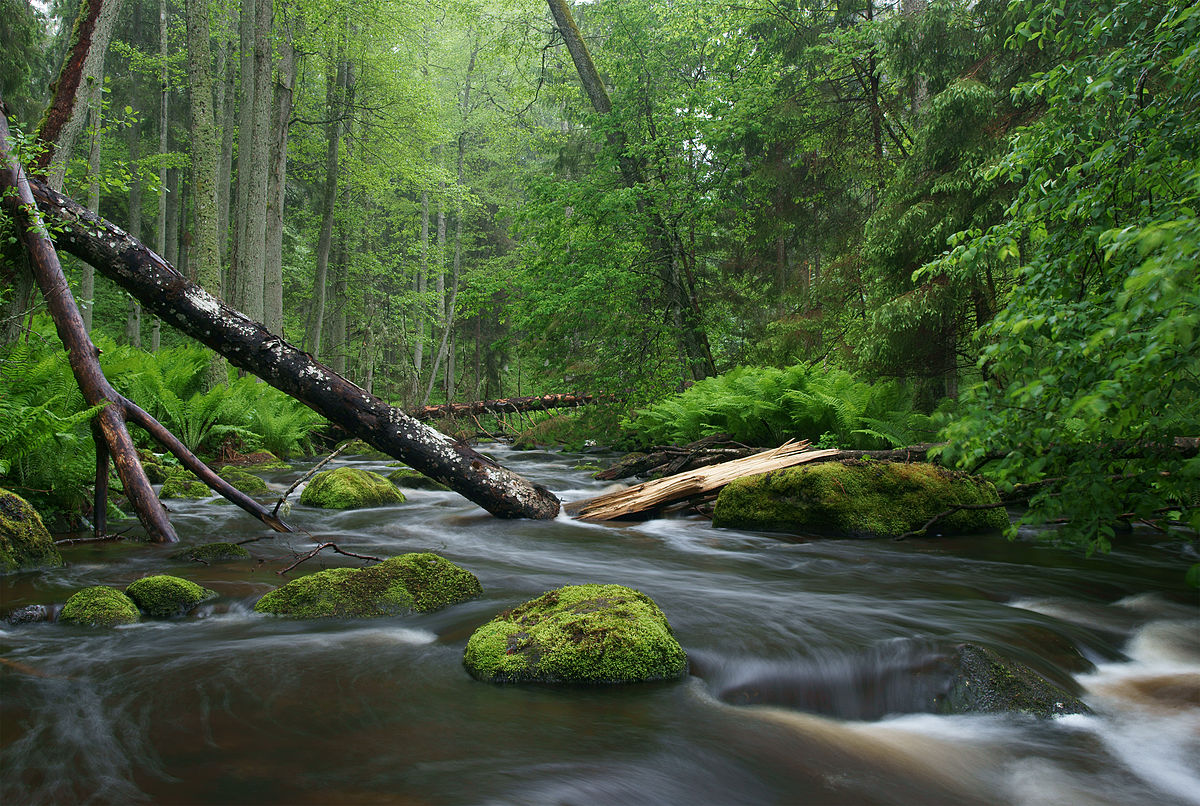

In [9]:
# Path to an empty image
blank_image_path = blank_imgs[2]
blank_image = os.path.join(blank_imgs_path, blank_image_path)
blank_image_pil = Image.open(blank_image)
blank_image_pil

In [10]:
# To determine the size and mode of the images
print(f"Antelope Image size: {antelope_img_Pil.size}")
print(f"Antelope Image mode: {antelope_img_Pil.mode}")

print(f"Antelope Image size: {antelope_img_Pil.size}")
print(f"Antelope Image mode: {antelope_img_Pil.mode}")

Antelope Image size: (550, 382)
Antelope Image mode: RGB
Antelope Image size: (550, 382)
Antelope Image mode: RGB


### Data Preparation

We need to ensure that all the images in the dtaset are in the same mode(RGB). Any image that is not in this mode will be automatically converted

In [77]:
# Create RGB converter
class rgbConverter:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

### Image Transformation

For image classification with PyTorch, it is best practice to standardize (normalize) the images so that they have consistent ranges 
and distributions, especially when using pretrained models.

In [79]:
# Create an image transformer
transform = transforms.Compose(
   [
       # Convert images to RGB if not aleardy 
       rgbConverter(),
       # Standadize all images to the same size
       transforms.Resize((224, 224)),

       # Convert th image to a Pytorch Tensor
       transforms.ToTensor()
   ]
)

In [80]:
# Load data using dataset
dataset = datasets.ImageFolder(root= train_dir, transform = transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 249
    Root location: data_binary\data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [81]:
dataset.classes

['antelope', 'blanks']

### Split Data

In [83]:
# Train validation split
g = torch.Generator()
g.manual_seed(42)

train_data, val_data =  random_split(dataset, [.8, .2], generator = g)

In [103]:
# To count how many images are in each class
from collections import Counter
def class_counts(dataset):
    count = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: count[idx] for cat, idx in class_to_index.items()})

In [104]:
# Breakdown of the training data in the dataset
train_count = class_counts(train_data)
train_count

100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


antelope     88
blanks      112
dtype: int64

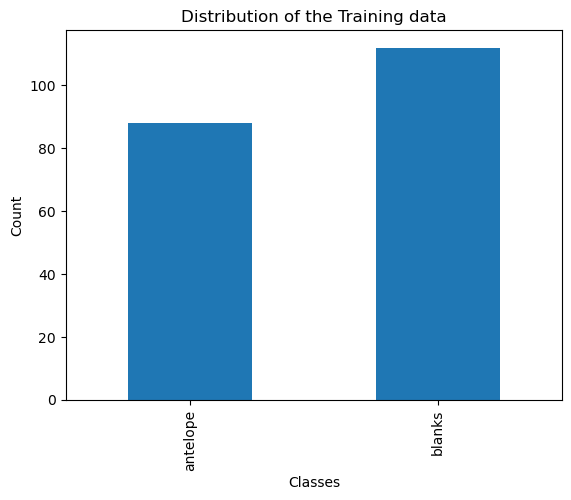

In [86]:
# Bar plot of the training dataset
train_count.sort_values().plot(kind = "bar"),

# Label Axis
plt.ylabel("Count"),
plt.xlabel("Classes"),

# Add  a title
plt.title("Distribution of the Training data");

In [87]:
# Breakdown of the validation data in the dataset
val_count = class_counts(val_data)
val_count

100%|██████████| 49/49 [00:05<00:00,  8.91it/s]


antelope    21
blanks      28
dtype: int64

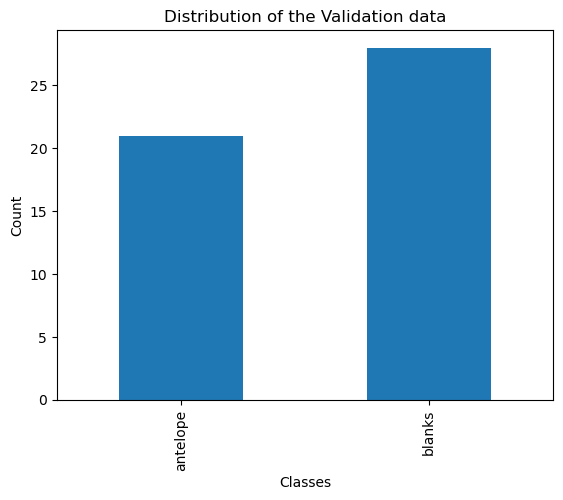

In [90]:
# Distribution of the validation dataset
val_count.sort_values().plot(kind = "bar")

# Add labels
plt.ylabel("Count"),
plt.xlabel("Classes"),

# Add a title
plt.title("Distribution of the Validation data");

### Create a Data Loader

In [138]:
# Create a data loader for the 
g = torch.Generator()
g.manual_seed(42)

# set batch size
batch_size = 8

# Train data loader
train_loader = DataLoader(train_data, batch_size = batch_size, generator = g, shuffle = True)

# Create a validation loader
val_loadr = DataLoader(val_data, batch_size =batch_size, generator = g, shuffle = False)

### Build a shallow neural network

The network will have 4 layers only

    - The input layer
    - Two hidden layer
    - The output layer

In [139]:
# To get one sample batch of image and label
train_iter = iter(train_loader)
images, label = next(train_iter)

# Image shape
images.shape

torch.Size([8, 3, 224, 224])

In [140]:
# Flatten the images 
flatten = nn.Flatten()
tensor_flatten = flatten(images)

### To Define the architecture of the Neural network

In [141]:
# Define image size from the transformer
height = 224
width = 224

# Neural netowrk
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU()
    
)

In [142]:
# Output layer
output_layer = nn.Linear(128, 2)
model.append(output_layer)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)

### Train Model

#### Define our loss function and an optimiser

`loss function` Measure how well the model performs for a given set of model parameters

`optimiser` adjusts models parameters to help reduce the loss function

In [143]:
# Defining the loss function
loss_fn = nn.CrossEntropyLoss()

In [144]:
# Define the loss function
optimiser = optim.Adam(model.parameters(), lr=0.001)

### Calculate Average Epoch loss for Training Data 

In [145]:
def train_epoch(model, optimiser, loss_fn, train_loader, device = "cpu"):
    """
    Returns the average loss per epoch,
    Puts the model in training mode,
    For each batch, reset the gradient, move data to device, compute predictions,compute loss, compute gradient, update wights and trak batch loss
    Parameters
    model: neural network
    optimser: Update the weights
    train_loader = Dataloader for the training dataset
    device: device where computation is done   
    """
    # Initializetraining loss
    training_loss = 0.0
    
    # To set the model to trainin mode
    model.train()

    # Iterate through all the batches in the train data
    for inputs, targets in tqdm(train_loader, desc = "Training", leave = False):
        # Zeroing the gradient
        optimiser.zero_grad()

        # Unpack the images and labels from the batches and add them to specific device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass, pass the inputs through the model to get the outputs(logits)
        output = model(inputs)
        loss = loss_fn(output, targets)

        # Back Propagation and update weights
        loss.backward()
        optimiser.step()

        # Track Training Loss
        training_loss += loss.data.item() * inputs.size(0)
    
    #Return Epoch loss
    return training_loss / len(train_loader.dataset)

#### Train model for one Epoch

In [152]:
# Average loss per epoch
loss_value = train_epoch(model, optimiser, loss_fn, train_loader)
print(f"Average loss during traninig was:  {loss_value:.3f}")

Average loss during traninig was:  9.834


In [154]:
# Average loss per epoch
loss_value = train_epoch(model, optimiser, loss_fn, train_loader)
print(f"Average loss during traninig was:  {loss_value:.4f}")

Average loss during traninig was:  0.9912


### Calculate Models Accuracy

In [148]:
# Validation Loop
def eval_epoch(model, train_loader, loss_fn, device = "cpu"):
    # Track total los and correct preictions
    validation_loss = 0.0
    correct_prediction = 0

    # Set the model to evaluation mode
    model.eval()

    # To turn off Gradient Tracking
    with torch.no_grad():
        for inputs, targets in tqdm(train_loader, desc = "Validation", leave = False):
            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass only {no backtracking}
            output = model(inputs)
            loss = loss_fn(output, targets)

            # Accumulate the loss
            validation_loss += loss.data.item() * inputs.size(0)

            # Get prediction classes
            _, pred = torch.max(output, dim = 1)
            correct_prediction += (pred == targets).sum().item()

    # Average loss across data
    avg_loss = validation_loss / len(train_loader.dataset)

    #Compute accuracy
    accuracy = correct_prediction / len(train_loader.dataset)

    return accuracy, avg_loss

In [153]:
val_loss, val_acc = eval_epoch(model, train_loader, loss_fn)
print(f"Validation loss: {val_loss}, \nValidation Accuracy: {(val_acc)* 100:.2f}")

Validation loss: 0.795, 
Validation Accuracy: 89.97
